# ODE : Initial Value Problems

Here we will study the numerical solution of ordinary differential equations with initial conditions specified.  We will only use the function `scipy.integrate.solve_ivp` for this purpose.  It is a general purpose solver with many options, only some of which we will explore.

## Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integ
import scipy.interpolate as interp
# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

## Documentation

We have already seen the documentation for `scipy.integrate` when we studied numerical integration.  Solving a system of differential equations is very much like numerical integration, in fact, we often say that we "integrate" the differential equations.

There are two main functions that are typically used within `scipy.integrate`: `solve_ivp`, the one we will use, and `odeint`, which appears in the "Old API" section.  In the past I have used `odeint`, you will find much code "in the wild" that uses it.  Thus, it would be good to be aware of its existence and to understand a little about it.  Regardless, we are only going to use `solve_ivp`, since, as the documentation for `odeint` states, all new code should use `solve_ivp`.

## `odeint` versus `solve_ivp`

Before looking at documentation let us briefly discuss the difference between these two functions. This is an aside, mostly with information for your edification.

When you look at the documentation for `scipy.integrate` you find an *Old API* section which contains `odeint`.  This is the interface that was used to solve initial value problems for years.  It has since been replaced by a more modern (and powerful) interface in `solve_ivp`. 

The two functions are similar in concept, but almost every choice that could be made differently between the two has been!  This means that these two are **not compatible**.  You cannot just switch between the two.  The way these functions are called, they way they call the function we provide for defining our system of differential equations, the defaults, ..., pretty much everything is different between the two!  I will leave it to you to explore all of the differences.  The ones that are of most importance to us are as follows.
1. `odeint` defaults to a "generic" solver that tries to guess the best method to use. `solve_ivp` defaults to a solver that works in many cases, but may not be optimal for all problems.
2. `odeint` has default tolerances of `1.49012e-8` for both absolute and relative tolerances. `solve_ivp` defaults to `rtol=1e-3` and `atol=1e-6`.  We will probably want to change these.
3. `odeint` requires an array of times at which to evaluate the solution to the differential equations, this information is used when solving the system. `solve_ivp` only requires the start and stop times for the solution, it will determine the points in-between as needed to achieve the desired accuracies. An array of times *can* be passed in, but is not required.
4. `odeint` accepts the `args=()` keyword option for passing extra arguments to the function we provide which defines the system of differential equations being solved. `solve_ivp` **did not** accept this keyword argument until a recent version.

Finally, I will mention that `solve_ivp` gives us much more control over what the solver is doing.  One example of this will also be mentioned in the prelab and lab, the `events` keyword.  This is a feature of many modern solvers in many numerical packages.  There is enough to learn without adding in the extra flexibility (and thus complication) so we will not use it, even though it could be used in many of the problems we will be solving.

## `solve_ivp`

Finally we are ready to check the documentation for `solve_ivp`.

In [2]:
integ.solve_ivp?

The most difficult part in using `solve_ivp` is to understand how to specify the differential equations and initial conditions.  Recall that `solve_ivp` solves a system of *first order* differential equations with initial values specified.  This encompasses a large class of problems we encounter in physics.

In its simplest form we can call this functions as
```
integ.solve_ivp(func, (tmin,tmax), y0)
```
Here `func` is a function that encodes the system of first order differential equations to be solved, `(tmin,tmax)` is the range of times over which we want to solve the system of first order differential equations, and `y0` is an array of initial conditions.

### Newton's Second Law

To be more clear how to specify the system of first order differential equations and the initial conditions, let us turn to a very common example in physics, Newton's second law,
$$
\frac{\mathrm{d}^2\vec r}{\mathrm{dt^2}} = \frac{\vec F(\vec r, \vec v, t)}{m}.
$$
Here we explicitly note that the force can be a function of position, velocity, and time.  Writing the vectors in terms of their components,
\begin{align}
\vec r &= x \hat\imath + y \hat\jmath + z \hat k, \\
\vec F &= F_x \hat\imath + F_y \hat\jmath + F_z \hat k,
\end{align}
we see that Newton's second law is a system of *second order* differential equations.  Recall that `solve_ivp` solves a system of *first order* differential equations, so what do we do?

We can turn *any* higher order differential equation into a *system of first order differential equations* by defining new variables that are the time derivatives of other ones.  For the case of Newton's second law this is a natural thing to do, in fact, we do it without thinking about it.  Consider just the differential equation for the $x$-coordinate,
$$
\frac{\mathrm{d}^2 x}{\mathrm{d}t^2} = \frac{F_x}{m}.
$$
We naturally define $v_x\equiv\mathrm{d}x/\mathrm{d}t$ so this second order differential equation can be written as the system of two first order differential equations,
\begin{align}
\frac{\mathrm{d}x}{\mathrm{d}t} &= v_x, \\
\frac{\mathrm{d}v_x}{\mathrm{d}t} &= \frac{F_x}{m}.
\end{align}

Applying this to the vector form of Newton's second law we have a system of *six* first order equations,
\begin{align}
\frac{\mathrm{d}\vec r}{\mathrm{d}t} &= \vec v, \\
\frac{\mathrm{d}\vec v}{\mathrm{d}t} &= \frac{\vec F}{m}.
\end{align}
To completely solve this system we need to specify one initial condition for each equation, so, six in total.  Again we know this from introductory physics: to describe the motion of a particle we need to specify its initial position and initial velocity.

The function, `func`, we pass to `solve_ivp` is the **right hand side of the system of differential equations to be solved.**  When `solve_ivp` is solving the system of equations it calls this function as
```
func(t, y, *args)
```
Here `t` is the current time step and the use of the symbol `y` can be confusing.  The `y` here represents an array of the quantities that appear in the derivatives on the left hand side of our system of differential equations.  For example, in the case of Newton's second law what we are calling `y` here could represent the position and velocity components: $(x, y, z, v_x, v_y, v_z)$.  Now we see why the choice is unfortunate, we are using the similar symbols `y` and $y$ to mean different things!  The order in which we construct this list is arbitrary, we can define it however we like. We do, however, need to use it consistently.  We must make sure `func` returns the right hand side in the same order and similarly the initial conditions, `y0`, must be specified in the same order.  This will be made more clear in the example below.

Though we have been discussing this in the context of Newton's second law it can be applied to **any** system of differential equations as noted above.  We only need to write the system in terms of first order differential equations, choose an ordering for `y`, write `func` to return the derivatives in this order, and specify the initial conditions in `y0` in the same order.

### Lambda functions: Extra arguments

As we saw above, `solve_ivp` now supports the `args=()` we have seen in many places. As discussed in class, an alternative to passing in extra arguments using `args` is to use a `lambda` function. Here is another description of `lambda` functions and their uses.

If you are familiar with functional programming then `lambda` functions are something you know.  Though Python is a procedural language (like C, FORTRAN, Java, *etc.*) there are many things that can be done using the functional programming paradigm.  Unfortunately we will not explore those here, we will focus on the one thing we need.

A simple way to understand them is that a `lambda` function is a simple function without a name that executes a single line of code and returns a value.  We can assign a `lambda` function to a variable, pass it to another function, *etc.*  Its basic structure is
```
lambda arg1,arg2: do something with arg1 and arg2
```
There can be an arbitrary number of arguments and the "do something" is a single statement/expression that uses the arguments and produces a value.  Notice that `return` is not needed and cannot be included.

As a simple example, suppose I wanted to define a cosine function that accepted angles in degrees instead of radians.  I could define this as a `lambda` function as
```
cosdeg = lambda theta: np.cos(np.deg2rad(theta))
```
Now if I do something like
```
cosdeg(60)
```
it should return 0.5.

This idea will be used below in the conjuction with `solve_ivp` (and in the future for other purposes).

Before proceeding let us verify that our simple example really does what we claim.

In [3]:
cosdeg = lambda theta: np.cos(np.deg2rad(theta))
cosdeg(60)

0.5000000000000001

## Simple Pendulum

In the numerical integration lab we studied the simple pendulum.  We will do the same here, now solving the differential equation.  From Newtonian mechanics for a pendulum oscillating in a plane of length $\ell$ in the presence of a constant gravitational field, $g$, the equation of motion is given by
$$
\frac{\mathrm{d}^2\theta}{\mathrm{d}t^2} = -\frac{g}{\ell} \sin\theta \equiv -\omega_0^2 \sin\theta.
$$
For convenience and for generality it is best to define $\omega_0\equiv\sqrt{g/\ell}$.

To solve this differential equation with `solve_ivp` we first need to turn it into a system of first order differential equations.  In this case, it is straight forward.  If we *define* $\omega\equiv\dot\theta$, then the system of first order differential equations is given by
\begin{align}
\frac{\mathrm{d}\theta}{\mathrm{d}t} &= \omega, \\
\frac{\mathrm{d}\omega}{\mathrm{d}t} &= -\omega_0^2 \sin\theta.
\end{align}
To fully specify a physical configuration we need to supply initial conditions at time $t=0$, that is, $\theta(0)$ and $\omega(0)$.

### Function Definition

We can now define a function to pass to `solve_ivp` that contains this system of differential equations.  We will include `omega0` as an extra parameter passed to the function.

Note that we **must document this function**.  Though in general we should always document any (nontrivial) function, when our function makes specific choices (here the order in which we store information in `y`) it is essential that these choices are clearly documented.

In [4]:
def pendulum_eom(t, y, omega0):
    """
    y stores values in the following order:
    y[0] = theta (radians)
    y[1] = omega (radians per time)

    omega0 is the 'natural frequency' of the pendulum
    for small oscillations and should also be given
    in units of radians per time.
    """
    dydt = np.zeros_like(y)
    dydt[0] = y[1]
    dydt[1] = -omega0**2 * np.sin(y[0])
    return dydt

### Test Case: Small Amplitude Oscillations

For small amplitude oscillations we know the solution to the equation of motion for the pendulum.  As always, when studying something new and when implementing something for the first time, it is best to begin with a simple test case with a known solution.

To begin, if we start with the pendulum at rest with some initial amplitude, $\theta_0$, then our initial conditions are $\theta(0)=\theta_0$ and $\omega(0)=0$.  In this case, when $\theta_0\ll 1$ we know that
$$ \theta(t) = \theta_0 \cos(\omega_0 t), \quad \omega(t) = -\theta_0\omega_0 \sin(\omega_0 t), $$
and the period of oscillations is
$$ T = \frac{2\pi}{\omega_0}. $$

As a very simple case, if we choose $\omega_0=2\pi$ per second, then $T=1$ second.  Let us see how to solve the differential equation and verify the results.

With every thing set up we can now just use `solve_ivp` to find the desired solution.

In [5]:
omega0 = 2*np.pi
# Initial conditions in the same order as used for pendulum_eom.
y0 = np.array([0.01, 0])
sol = integ.solve_ivp(lambda t, y: pendulum_eom(t, y, omega0), (0, 1.1), y0,
                      vectorized=True, atol=1e-12, rtol=1e-12)

What did we just do and what did we get in return?

Recall that `solve_ivp` requires a few arguments and that there are others we may want to pass in.  In this case we should notice the following.
1. The first argument to `solve_ivp` is a function that accepts `t` and `y` and returns the values of the derivatives for these inputs.  Our function, `pendulum_eom`, takes an extra argument, `omega0`, so we have used a `lambda` function to pass this in.  (We could have instead not used a `lambda` function and pass in the extra argument using `args=(omega0)`.) The `lambda` function accepts the `t,y` arguments, passes them on to `pendulum_eom` along with a fixed value of `omega0`.
2. The second argument to `solve_ivp` are the initial and final times over which we will solve the differential equations.  Here I chose a range slightly larger than one period.
3. The third argument to `solve_ivp` are the initial conditions stored in the array `y0`.  These must be stored in the same order as we store the derivatives that are returned by `pendulum_eom`.  The order is arbitrary, but we must consistently use the order we have chosen.
4. The rest of the arguments are optional.  I have chosen to tell `solve_ivp` that our function is vectorized.  This means that if an array of times along with a two-dimensional array of `y` values are passed in, the function will calculate all the derivative for all the times, at once.  We will frequently write functions that are vectorized without even trying to (but not always, for example in the lab we may not) and in principle `solve_ivp` can be more efficient if it has a vectorized function.
5. I also chose to make the tolerances much smaller so that we will (hopefully) get more accurate results.
6. You will also notice that I **did not** specify at what times to calculate the solutions.  This could have been done by passing in an array of times using the `t_eval` keyword.

The results are stored in the return value from `solve_ivp`, what I have called `sol`.  Let us see what it is and what it contains.

In [6]:
type(sol)

scipy.integrate._ivp.ivp.OdeResult

The type is not very instructive, it is some object defined specifically to return information from `solve_ivp`.  We can get information about it in the usual ways.

In [7]:
sol?

As we see, this is essentially a dictionary, so we can access its information in standard Python ways.

In [8]:
sol.keys()

dict_keys(['t', 'y', 'sol', 't_events', 'y_events', 'nfev', 'njev', 'nlu', 'status', 'message', 'success'])

Some of the relevant fields are `success` and `message`, which tell us whether `solve_ivp` thinks it actually solved the system, that is, whether it converged or not.

In [ ]:
print(f'''Did solve_ivp succeed? {sol.success}.
The message it returned is "{sol.message}"''')

The most important fields are those that contain the results, `t` and `y`.  These contain the times at which the solutions were calculated and the solutions themselves, respectively.

In [10]:
print("t =", sol.t)
print("y =", sol.y)

t = [0.         0.00204566 0.0064623  0.01088045 0.01530051 0.01972314
 0.02414899 0.02857874 0.03301307 0.03745264 0.04189814 0.04635029
 0.05080979 0.05527736 0.05975376 0.06423975 0.06873612 0.07324368
 0.07776326 0.08229574 0.08684203 0.09140306 0.09597983 0.10057337
 0.10518477 0.10981517 0.11446578 0.11913789 0.12383287 0.12855217
 0.13329735 0.1380701  0.14287222 0.14770567 0.15257257 0.15747524
 0.16241621 0.16739827 0.1724245  0.17749831 0.18262349 0.1878043
 0.19304551 0.19835249 0.20373131 0.20918879 0.21473262 0.2203713
 0.22611396 0.23196984 0.23794691 0.24404908 0.25027106 0.25659086
 0.26296437 0.26932909 0.27562211 0.28180015 0.28784461 0.29375459
 0.29953799 0.30520584 0.31076944 0.31623925 0.32162455 0.32693347
 0.3321731  0.33734958 0.3424683  0.34753399 0.35255084 0.35752256
 0.36245246 0.36734352 0.37219844 0.37701967 0.38180943 0.38656976
 0.39130254 0.39600951 0.40069228 0.40535235 0.40999112 0.41460991
 0.41920994 0.4237924  0.42835838 0.43290893 0.43744505 0.44

How is `y` structured?  Let us look.

In [11]:
print(f'''Number of times: {len(sol.t)}
Shape of y: {sol.y.shape}''')

Number of times: 227
Shape of y: (2, 227)


So we see that `y` has 2 rows and as many columns as it needs (one for each time in `t`).  The order of the rows is the same as we chose in our function `pendulum_eom`.  For our choice this means `y[0]` is $\theta(t)$ and `y[1]` is $\omega(t)$.

To verify this let us plot these two along with the known results. (It would be better to plot the absolute difference between the two in order to gauge the size of the errors, but this is nicer to look at.)

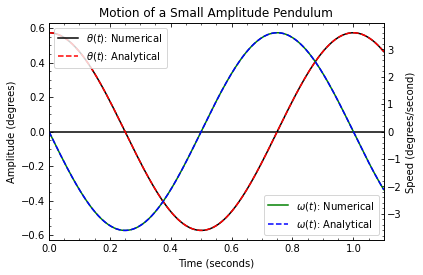

In [12]:
fig = plt.figure()
# For amusement we show how to produce a plot with
# different scales on the left and right axes.
axtheta = fig.add_subplot(111)
axomega = axtheta.twinx()
axtheta.axhline(0, color='k')
axtheta.plot(sol.t, np.rad2deg(sol.y[0]), 'k-', label=r'$\theta(t)$: Numerical')
axtheta.plot(sol.t, np.rad2deg(y0[0]*np.cos(omega0*sol.t)), 'r--',
             label=r'$\theta(t)$: Analytical')
axomega.plot(sol.t, np.rad2deg(sol.y[1]), 'g-', label=r'$\omega(t)$: Numerical')
axomega.plot(sol.t, np.rad2deg(-y0[0]*omega0*np.sin(omega0*sol.t)), 'b--',
             label=r'$\omega(t)$: Analytical')
axtheta.legend(loc='upper left')
axomega.legend(loc='lower right')
axtheta.set_xlabel('Time (seconds)')
axtheta.set_ylabel('Amplitude (degrees)')
axomega.set_ylabel('Speed (degrees/second)')
axtheta.set_title('Motion of a Small Amplitude Pendulum')
axtheta.set_xlim(0, 1.1);

Those plots look in good agreement.  We can also calculate the period.  How should we do this?  A simple way is to look for the times where $\omega(t)=0$, the extrema of the plot.  Since we have calculated this over one period, the last time at which this is true will be the period of the oscillation.  We can do this using a spline.  If you look at the documentation for `InterpolatedUnivariateSpline` we find that if we use a cubic spline, then we can also directly get the roots of this spline! (This is one of many peculiarities of the api.)

In [13]:
omega_t_spline = interp.InterpolatedUnivariateSpline(sol.t, sol.y[1])
roots = omega_t_spline.roots()
print("Period =", roots[-1], "seconds, expected = 1 second")

Period = 1.0000062500352112 seconds, expected = 1 second


### Larger Amplitude Test

Since the small amplitude test was successful, we can now try it for a larger amplitude.  Here we use $\theta(0)=10$ and make a quick plot of the amplitude as compared to the the amplitude from the small amplitude approximation.

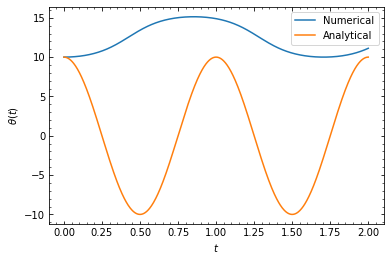

In [14]:
y0 = np.array([10., 0])
sol = integ.solve_ivp(lambda t, y: pendulum_eom(t, y, omega0), (0, 2), y0,
                      vectorized=True, atol=1e-12, rtol=1e-12)
plt.plot(sol.t, sol.y[0], label='Numerical')
plt.plot(sol.t, y0[0]*np.cos(omega0*sol.t), label='Analytical')
plt.xlabel('$t$')
plt.ylabel(r'$\theta(t)$')
plt.legend();

What happened? This is physically impossible!  The numerical solution never goes to zero!

To understand this we need to think back to what we are actually doing and the choices we have made.  What does $\theta(0)=10$ mean?  It is not just a large number, it is a physically nonsensical initial condition.  Recall that $\theta$ is specified in radians.  What is 10 radians? Well, $\pi$ is about 3.14 radians, so we are specifying $\theta(0)>\pi$.  That does not make sense physically, hence, numerically we still get a result, but it is nonsensical.

If we meant to specify 10 degrees, then we would find...

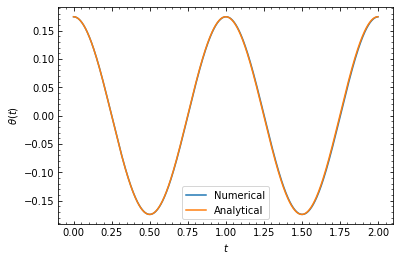

In [15]:
y0 = np.array([np.deg2rad(10.), 0])
sol = integ.solve_ivp(lambda t, y: pendulum_eom(t, y, omega0), (0, 2), y0,
                      vectorized=True, atol=1e-12, rtol=1e-12)
plt.plot(sol.t, sol.y[0], label='Numerical')
plt.plot(sol.t, y0[0]*np.cos(omega0*sol.t), label='Analytical')
plt.xlabel('$t$')
plt.ylabel(r'$\theta(t)$')
plt.legend();

So we see that this is still in good agreement with the small amplitude approximation.  10 degrees is not that large of a deviation.

### Period versus Amplitude

With all of this understood, we can now do many things.  Here is one of them.  Here we will do something similar to the previous lab (though in far less detail) and calculate the period as a function of amplitude.  This is a less efficient way to do what we did in the lab since here we are solving for the full motion of the pendulum which is overkill if we only want the period.  Note that this does require a loop.  *This is slow!*  We actually have to wait for it to run!

In [16]:
# Consider a range of periods.
theta0deg = np.arange(1, 150)
theta0 = np.deg2rad(theta0deg)
# Array to store the results
period = np.zeros_like(theta0)
for j in range(len(theta0)):
    y0 = np.array([theta0[j], 0])
    # Pick a large enough time range so that we can get at least one period.
    # This is "hand picked" and depends on the choice of omega0.
    sol = integ.solve_ivp(lambda t, y: pendulum_eom(t, y, omega0), (0, 5), y0,
                          vectorized=True, atol=1e-12, rtol=1e-12)
    omega_t_spline = interp.InterpolatedUnivariateSpline(sol.t, sol.y[1])
    roots = omega_t_spline.roots()
    # Find the period.  We do this by finding the second time that omega(t)=0
    # for t>0.  Due to numerical precision, it is possible that the first time
    # will be a very small number close to zero.  We want to skip this time.
    # Thus the index of the root we want will either be 1 or 2, depending on
    # the size of the first root.
    ind = 1
    if np.abs(roots[0]) < 0.1:
        ind += 1
    period[j] = roots[ind]

Finally, we plot the results in a way similar to that from the previous lab.  Recall that the small amplitude period is 1 second.

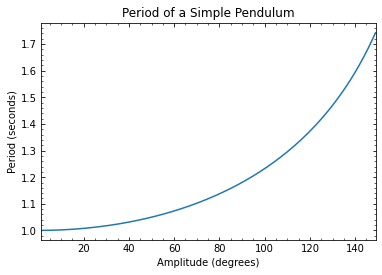

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(theta0deg, period)
ax.set_xlabel('Amplitude (degrees)')
ax.set_ylabel('Period (seconds)')
ax.set_title('Period of a Simple Pendulum')
ax.set_xlim(theta0deg[0], theta0deg[-1]);

### Other Cases

With the code we have written we can now apply it to any case we want.  As one more example, let us consider a pendulum of length $\ell=2\;\mathrm{m}$, have the bob of the pendulum start at its lowest point, and give it an initial angular speed of 20 degrees/second.

To apply this case we first need to convert these parameters to those used in our code.

In [18]:
length = 2  # m
omega0 = np.sqrt(9.8/length)  # This is sqrt(g/l)
angspeed = np.deg2rad(20.)  # Convert speed to radians per second.

Now we can use these to solve for the motion and produce a nice plot. As noted above, `solve_ivp` does support `args`. To see this, instead of using a `lambda` function, we will use `args` here.

In [19]:
y0 = np.array([0., angspeed])
# Maximum time arbitrarily chosen
sol = integ.solve_ivp(pendulum_eom, (0, 5.), y0, args=(omega0),
                      vectorized=True, atol=1e-12, rtol=1e-12)

TypeError: Value after * must be an iterable, not numpy.float64

But it did not work! We got an error! What is going on?

The error gives a hint. `args` must be "an iterable", but `(omega0)` is ambiguous. Consider, for example, the code
```
example = (8)
```
what will this do? Let us see ...

In [ ]:
example = (8)
print(f"{example=}")

We did not get a tuple, we just got a number!

This makes sense. In a mathematical expression we can write things like
```
example = (2)*(4 + 1/2)
```
and we expect this to return 9; we do not expect an error. If `(2)` were interpreted as a tuple, then this would be an error, and we would get very frustrated.

In [ ]:
example = (2)*(4 + 1/2)
print(f"{example=}")

So, if we have a single number and want to create an iterable, what should we do?

There are a few options. One is to force a tuple by including an empty second element of the tuple, ie., just include a comma.
```example1 = (8,)```

Alternatively, we could use a list instead of a tuple. There is no ambiguity in the construction of list.
```example2 = [8]```

In [ ]:
example1 = (8,)
example2 = [8]
print(f"{example1=}, {example2=}")

In [ ]:
# Maximum time arbitrarily chosen.
# Here we show forcing a tuple.
sol = integ.solve_ivp(pendulum_eom, (0, 5.), y0, args=(omega0,),
                      vectorized=True, atol=1e-12, rtol=1e-12)
fig = plt.figure()
# For amusement we show how to produce a plot with
# different scales on the left and right axes.
axtheta = fig.add_subplot(111)
axomega = axtheta.twinx()
axtheta.axhline(0, color='k')
axtheta.plot(sol.t, np.rad2deg(sol.y[0]), 'k-', label=r'$\theta(t)$')
axomega.plot(sol.t, np.rad2deg(sol.y[1]), 'g-', label=r'$\omega(t)$')
axtheta.legend(loc='lower left')
axomega.legend(loc='upper right')
axtheta.set_xlabel('Time (seconds)')
axtheta.set_ylabel('Amplitude (degrees)')
axomega.set_ylabel('Speed (degrees/second)')
axtheta.set_title('Motion of Pendulum')
axtheta.set_xlim(sol.t[0], sol.t[-1]);

Finally, we can do the same thing but now give the pendulum a very large initial speed.

In [ ]:
angspeed = np.deg2rad(300.) # Convert speed to radians per second.
y0 = np.array([0., angspeed])
# Maximum time arbitrarily chosen
# Here we show using a list.
sol = integ.solve_ivp(pendulum_eom, (0, 5.), y0, args=[omega0],
                      vectorized=True, atol=1e-12, rtol=1e-12)
fig = plt.figure()
# For amusement we show how to produce a plot with
# different scales on the left and right axes.
axtheta = fig.add_subplot(111)
axomega = axtheta.twinx()
#axtheta.axhline(0, color='k')
axtheta.plot(sol.t, np.rad2deg(sol.y[0]), 'k-', label=r'$\theta(t)$')
axomega.plot(sol.t, np.rad2deg(sol.y[1]), 'g-', label=r'$\omega(t)$')
axtheta.legend(loc='upper left')
axomega.legend(loc='lower right')
axtheta.set_xlabel('Time (seconds)')
axtheta.set_ylabel('Amplitude (degrees)')
axomega.set_ylabel('Speed (degrees/second)')
axtheta.set_title('Motion of Pendulum')
axtheta.set_ylim(bottom=0)
axtheta.set_xlim(sol.t[0], sol.t[-1]);

You can think about and explain why this behavior makes sense!